In [1]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
^C


In [10]:
!pip install torch torchvision torchaudio


In [40]:
#import shutil

# Define the directory to be removed
#directory_path = '/home3/jqwx33/SculptureMTL/LibMTL/LibMTL/LibMTL'

# Remove the directory
#shutil.rmtree(directory_path)




In [1]:
!git clone https://github.com/median-research-group/LibMTL.git
%cd LibMTL
!pip install -r requirements.txt
!pip install -e .

fatal: destination path 'LibMTL' already exists and is not an empty directory.
/home3/jqwx33/SculptureMTL/LibMTL
  Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Using cached Pillow-10.1.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.5 MB)
ERROR: Could not find a version that satisfies the requirement torch==1.8.1+cu111 (from -r requirements.txt (line 11)) (from versions: 1.4.0, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0)
ERROR: No matching distribution found for torch==1.8.1+cu111 (from -r requirements.txt (line 11))
Obtaining file:///home3/jqwx33/SculptureMTL/LibMTL
  Attempting uninstall: LibMTL
    Found existing installation: LibMTL 1.1.5
    Uninstalling LibMTL-1.1.5:
      Successfully uninstalled LibMTL-1.1.5
  Running setup.py develop for LibMTL


In [2]:
import os
import sys

os.environ['PATH'] += ':/home3/jqwx33/.local/bin'

sys.path.append('/home3/jqwx33/.local/lib/python3.8/site-packages')

sys.path.append('/home3/jqwx33/MTLexample/LibMTL/LibMTL')

file_path = '/home3/jqwx33/SculptureMTL/LibMTL'
if file_path not in sys.path:
    sys.path.append(file_path)

print(os.getcwd())


/home3/jqwx33/SculptureMTL/LibMTL


In [3]:
import torch
torch.cuda.empty_cache()

import gc
gc.collect()

0

In [4]:
import sys
import importlib

# Delete all modules starting with 'LibMTL'
for module in list(sys.modules.keys()):
    if module.startswith('LibMTL'):
        del sys.modules[module]

# Re-import the LibMTL module
import LibMTL

# Re-import the required submodules
importlib.reload(LibMTL)

# #from LibMTL.metrics import AccMetric

from LibMTL.loss import CELoss, BCEWLoss

# Check if the import was successful
print(hasattr(CELoss, 'compute_loss'))
print(hasattr(BCEWLoss, 'compute_loss'))


True
True


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse

import pandas as pd
from PIL import Image
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler,Subset

import matplotlib.pyplot as plt


In [6]:
from utils import *
#from aspp import DeepLabHead
#from create_dataset import NYUv2
from LibMTL import Trainer
#from LibMTL.model import resnet_dilated
from LibMTL.model.resnet import resnet50
from LibMTL.utils import set_random_seed, set_device
from LibMTL.config import LibMTL_args, prepare_args


In [7]:
from LibMTL.loss import CELoss,  FocalLoss
from LibMTL.metrics import F1Metric, AccMetric
from LibMTL._record import _PerformanceMeter


In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Argument Parsing

In [9]:
import argparse
import sys

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--csv_file', default='/home3/jqwx33/SculptureMTL/sculpture-multi-class-remove-unknown.csv', type=str, help='path to the csv file')
    parser.add_argument('--img_dir', default='/home3/jqwx33/SculptureMTL/selected_images', type=str, help='directory of images')
    parser.add_argument('--train_bs', default=10,type=int, help='batch size for training')
    parser.add_argument('--test_bs', default=10, type=int, help='batch size for testing')
    parser.add_argument('--epochs', default=40,type=int, help='training epochs')
    parser.add_argument('--weighting', default='DWA', type=str, help='weighting strategy')
    parser.add_argument('--arch', default='MTAN', type=str, help='MTL architecture')
    parser.add_argument('--gpu_id', default='0', type=str, help='gpu id')
    parser.add_argument('--seed', default=0, type=int, help='random seed')
    parser.add_argument('--scheduler', default='step', type=str, help='learning rate scheduler type')
    parser.add_argument('--optim', default='adamw', type=str, help='optimizer type')
    parser.add_argument('--mode', default='test', type=str, help='mode: train or test')
    
    parser.add_argument('--save_path', default='/home3/jqwx33/SculptureMTL/result-nounkonwn2', type=str, help='save path')
    parser.add_argument('--load_path', default='/home3/jqwx33/SculptureMTL/result-nounkonwn2/best.pt', type=str, help='load path for testing')
    parser.add_argument('--T', default=2, type=int, help='DWA parameter T')
    parser.add_argument('--step_size', default=50, type=int, help='scheduler step size')
    parser.add_argument('--gamma', default=0.5, type=float, help='scheduler gamma')
    parser.add_argument('--lr', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--weight_decay', default=0.0005, type=float, help='weight decay')
    parser.add_argument('--rep_grad', action='store_true', default=False, help='compute representative gradients')
    parser.add_argument('--multi_input', action='store_true', default=False, help='multi-input')
    if sys.argv and sys.argv[0].endswith('ipykernel_launcher.py'):
        args = parser.parse_args(args=[])
    else:
        args = parser.parse_args()
    return args


## Dataset  Definition

In [10]:

class SculptureDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        self.image_paths = self.data['image_path'].tolist()
  
        self.materials_col = 'materials_encoded'
        self.genres_col = 'genres_encoded'
        self.time_period_col = 'years_encoded'
        
         # Remove any rows with NaN values
        self.data = self.data.dropna(subset=[self.materials_col, self.genres_col, self.time_period_col])

        self.data[self.materials_col] = self.data[self.materials_col].apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.int64)
        self.data[self.genres_col] = self.data[self.genres_col].apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.int64)
        self.data[self.time_period_col] = pd.to_numeric(self.data[self.time_period_col], errors='coerce').fillna(0).astype(np.int64)


        
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_paths[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        materials = self.data.iloc[idx][self.materials_col].astype(np.int64)
        genres = self.data.iloc[idx][self.genres_col].astype(np.int64)
        time_period = self.data.iloc[idx][self.time_period_col].astype(np.int64)

        return image, {'materials': torch.tensor(materials, dtype=torch.long),
                       'genres': torch.tensor(genres, dtype=torch.long),
                       'time_period': torch.tensor(time_period, dtype=torch.long)}


        
# Reshape layer for decoder
class ReshapeLayer(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)


    
    

## Model and Training Configuration


In [12]:
#train+adamw 7:3；drop0.6

# Main function to set up and run the model
def main(params):
    
    if not os.path.exists(params.save_path):
        os.makedirs(params.save_path)
        

    # Prepare arguments for optimizer and scheduler
    kwargs, optim_param, scheduler_param = prepare_args(params)

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.RandomRotation(30),      # Randomly rotate the image by 30 degrees
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # standardization


    ])

    dataset = SculptureDataset(csv_file=params.csv_file, img_dir=params.img_dir, transform=transform)

  # Split the dataset into training, validation, and test sets
    train_idx, temp_idx = train_test_split(range(len(dataset)), test_size=0.3, random_state=params.seed)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=params.seed)   # Split the remaining 20% into validation and test sets



    train_set = Subset(dataset, train_idx)
    val_set = Subset(dataset, val_idx)
    test_set = Subset(dataset, test_idx)
    

    train_loader = DataLoader(train_set, batch_size=params.train_bs, shuffle=True, num_workers=2, pin_memory=True, drop_last=False)
    val_loader = DataLoader(val_set, batch_size=params.test_bs, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_set, batch_size=params.test_bs, shuffle=False, num_workers=2, pin_memory=True)


    # Define tasks and metrics
    task_dict = {
        'materials': {
            'metrics': ['acc'],
            'metrics_fn': AccMetric(),
            'loss_fn': CELoss(),
            'weight': [1]
        },
        'genres': {
            'metrics': ['acc'],
            'metrics_fn': AccMetric(),
            'loss_fn': CELoss(),
            'weight': [1]
        },
        'time_period': {
            'metrics': ['acc'],
            'metrics_fn': AccMetric(),
            'loss_fn': CELoss(),
            'weight': [1]
        }
    }

    
    # Function to return the encoder class
    def encoder_class():
        return resnet50(pretrained=True)

    class SculptureEncoder(nn.Module):
        def __init__(self):
            super(SculptureEncoder, self).__init__()
            self.encoder = resnet50(pretrained=True)  #use ResNet-50

        def forward(self, x):
            x = self.encoder(x)
            print("Encoder output shape:", x.shape)
            return x




    # Initialize encoder to get the output shape
    
    encoder = SculptureEncoder()
    dummy_input = torch.randn(1, 3, 256, 256)
    encoder_output = encoder(dummy_input)
    flattened_size = encoder_output.view(1, -1).size(1)
    
    num_out_channels = {
    'materials': len(np.unique(dataset.data[dataset.materials_col])),
    'genres': len(np.unique(dataset.data[dataset.genres_col])),
    'time_period': len(np.unique(dataset.data[dataset.time_period_col]))
}

    
    #Decoder class for each task
    
    
    class Decoder(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(Decoder, self).__init__()
            self.decoder = nn.Sequential(
                ReshapeLayer(),
                nn.Linear(input_dim, 512),
                nn.ReLU(),
                nn.Dropout(p=0.6),
                nn.Linear(512, output_dim),
            )
        def forward(self, x):
            return self.decoder(x)
        

#     class Decoder(nn.Module):
#         def __init__(self, input_dim, output_dim):
#             super(Decoder, self).__init__()
#             self.decoder = nn.Sequential(
#                 ReshapeLayer(),
#                 nn.Linear(input_dim, output_dim)
#             )

#         def forward(self, x):
#             return self.decoder(x)

    decoders = nn.ModuleDict({task: Decoder(flattened_size, num_out_channels[task]) for task in task_dict.keys()})
    
    
    # Trainer class for the sculpture model

    class SculptureTrainer(Trainer):
        def __init__(self, task_dict, weighting, architecture, encoder_class, decoders, rep_grad, multi_input, optim_param, scheduler_param, **kwargs):
            super(SculptureTrainer, self).__init__(task_dict=task_dict, weighting=weighting, architecture=architecture, encoder_class=encoder_class, decoders=decoders, rep_grad=rep_grad, multi_input=multi_input, optim_param=optim_param, scheduler_param=scheduler_param, **kwargs)
            

        def process_preds(self, preds):
            return preds

        def _process_data(self, loader):
            try:
                data, label = next(loader[1])
            except:
                loader[1] = iter(loader[0])
                data, label = next(loader[1])
            inputs = data.to(self.device, non_blocking=True)
            labels = {task: label[task].to(self.device, non_blocking=True) for task in self.task_name}
            return inputs, labels




    SculptureModel = SculptureTrainer(task_dict=task_dict, weighting=params.weighting, architecture=params.arch, encoder_class=encoder_class, decoders=decoders,
                                      rep_grad=params.rep_grad, multi_input=params.multi_input, optim_param=optim_param, scheduler_param=scheduler_param,
                                      save_path=params.save_path, load_path=params.load_path, **kwargs)

    if params.mode == 'train':
        try:
            SculptureModel.train(train_loader, val_loader, params.epochs)


        finally:
            torch.cuda.empty_cache()
    elif params.mode == 'test':
        try:
            SculptureModel.test(test_loader)
        finally:
            torch.cuda.empty_cache()
    else:
        raise ValueError("Invalid mode. Choose between 'train' and 'test'.")

if __name__ == "__main__":
    params = parse_args()
    set_device(params.gpu_id)
    set_random_seed(params.seed)
    main(params)


General Configuration:
	Mode: train
	Wighting: DWA
	Architecture: MTAN
	Rep_Grad: False
	Multi_Input: False
	Seed: 0
	Save Path: /home3/jqwx33/SculptureMTL/result-nounkonwn2
	Load Path: None
	Device: cuda:0
DWA Configuration:
	T: 2
Optimizer Configuration:
	optim: adamw
	lr: 0.001
	weight_decay: 0.0005
Scheduler Configuration:
	scheduler: step
	step_size: 50
	gamma: 0.5
Encoder output shape: torch.Size([1, 2048, 8, 8])
Total Params: 245312289
Trainable Params: 245312289
Non-trainable Params: 0
LOG FORMAT | materials_LOSS acc | genres_LOSS acc | time_period_LOSS acc | TIME
Epoch: 0000 | TRAIN: 2.3267 0.2902 | 2.0323 0.5789 | 2.6756 0.2145 | Time: 122.0732 | TEST: 1.7599 0.3152 | 1.4660 0.5978 | 2.0285 0.2319 | Time: 6.3484
Save Model 0 to /home3/jqwx33/SculptureMTL/result-nounkonwn2/best.pt
Epoch: 0001 | TRAIN: 1.6931 0.3551 | 1.4673 0.6099 | 2.0438 0.2358 | Time: 121.5104 | TEST: 1.7019 0.3261 | 1.3650 0.6286 | 1.9431 0.2717 | Time: 6.2492
Save Model 1 to /home3/jqwx33/SculptureMTL/res

## Test and visualization

General Configuration:
	Mode: test
	Wighting: DWA
	Architecture: MTAN
	Rep_Grad: False
	Multi_Input: False
	Seed: 0
	Save Path: /home3/jqwx33/SculptureMTL/result-nounkonwn2
	Load Path: /home3/jqwx33/SculptureMTL/result-nounkonwn2/best.pt
	Device: cuda:0
DWA Configuration:
	T: 2
Optimizer Configuration:
	optim: adamw
	lr: 0.001
	weight_decay: 0.0005
Scheduler Configuration:
	scheduler: step
	step_size: 50
	gamma: 0.5
Encoder output shape: torch.Size([1, 2048, 8, 8])
Load Model from - /home3/jqwx33/SculptureMTL/result-nounkonwn2/best.pt
Total Params: 245312289
Trainable Params: 245312289
Non-trainable Params: 0
LOG FORMAT | materials_LOSS acc | genres_LOSS acc | time_period_LOSS acc | TIME
TEST: 1.4130 0.5471 | 1.2262 0.6757 | 1.7874 0.3062 | Time: 6.2248


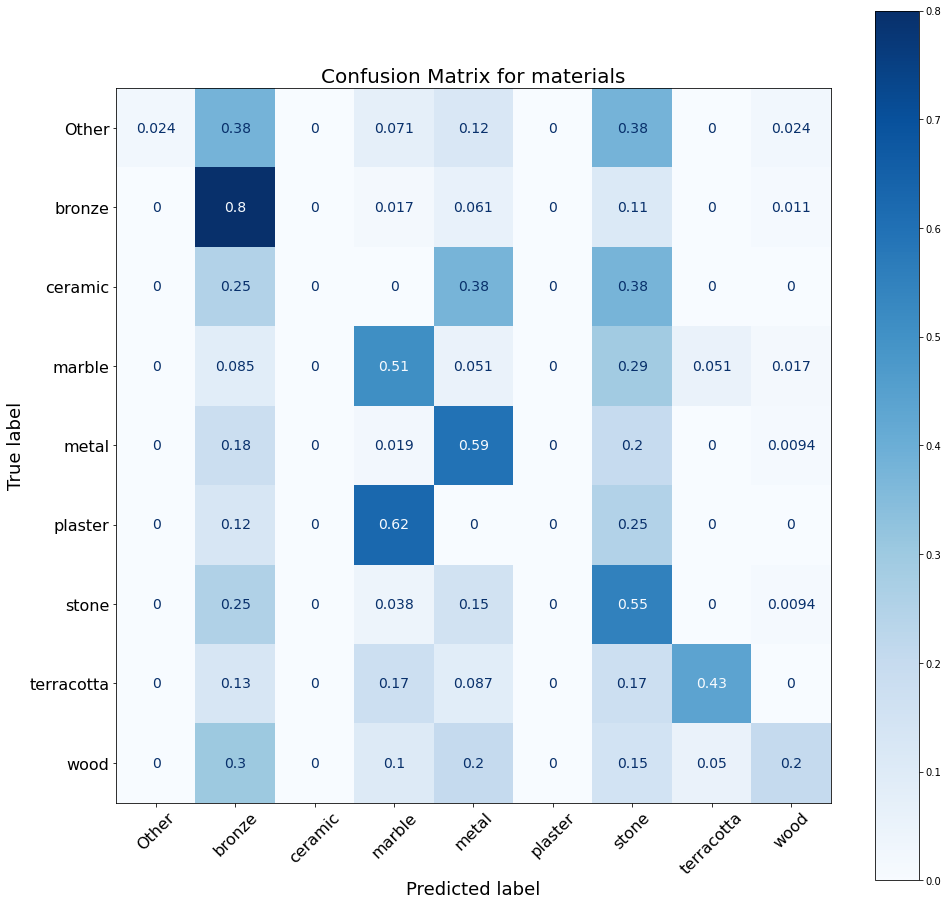

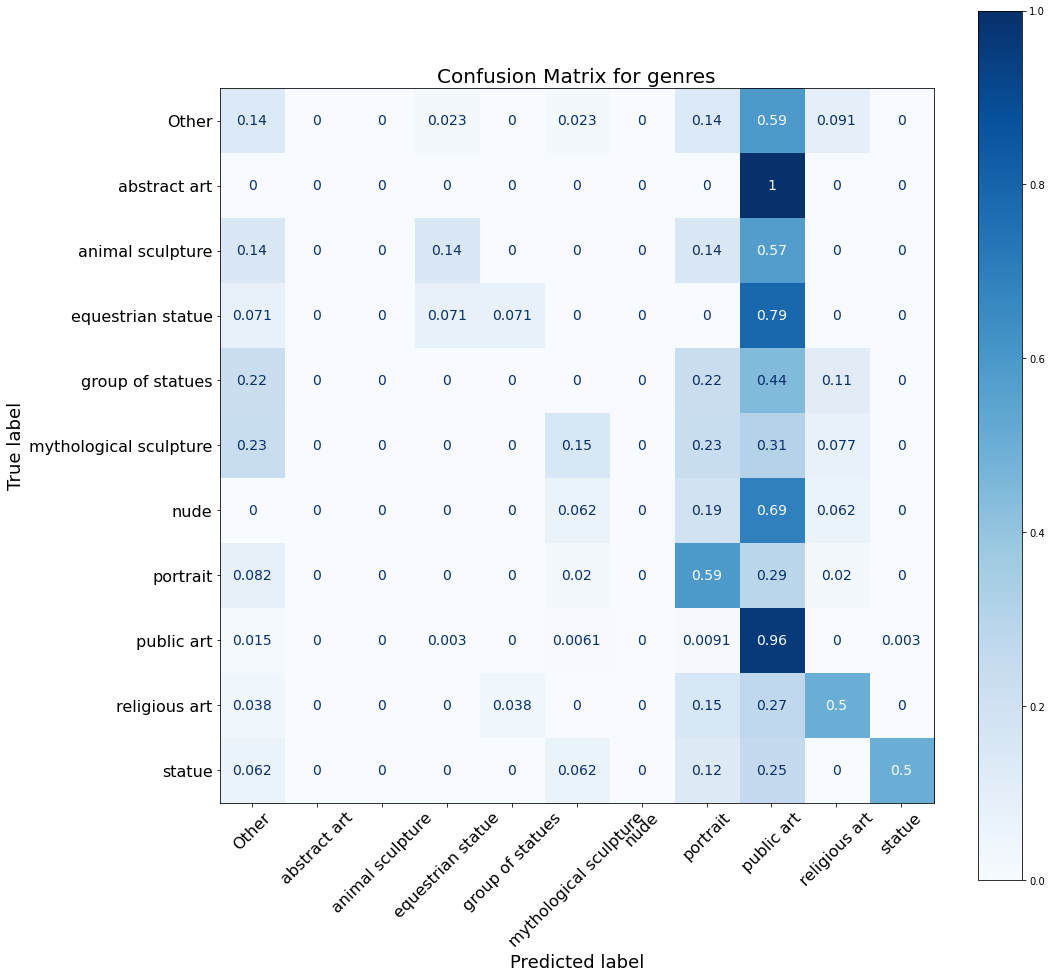

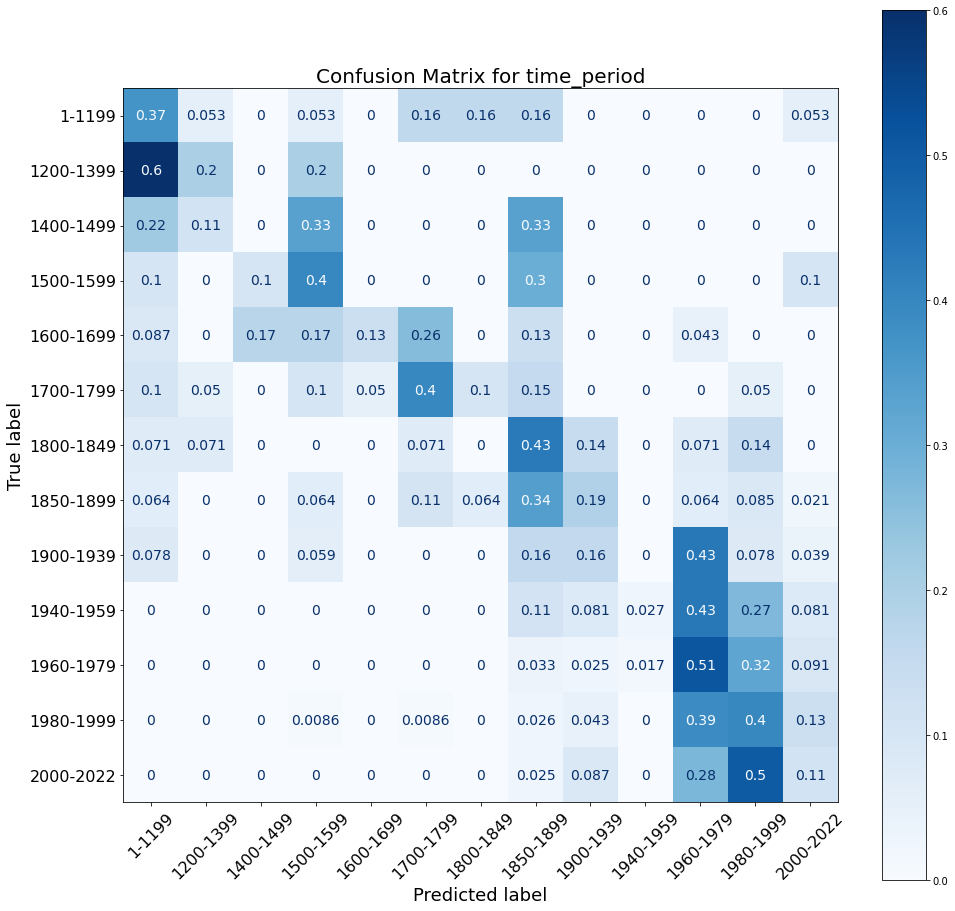

In [21]:
#test+adamw 7:3；drop0.6

# Main function to set up and run the model
def main(params):
    
    if not os.path.exists(params.save_path):
        os.makedirs(params.save_path)
        

    # Prepare arguments for optimizer and scheduler
    kwargs, optim_param, scheduler_param = prepare_args(params)

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.RandomRotation(30),      # Randomly rotate the image by 30 degrees
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # standardization

    ])

    dataset = SculptureDataset(csv_file=params.csv_file, img_dir=params.img_dir, transform=transform)

    # spliy the dataset into training, validation and test sets
    train_idx, temp_idx = train_test_split(range(len(dataset)), test_size=0.3, random_state=params.seed)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=params.seed)   # Split the remaining 20% into validation and test sets








    train_set = Subset(dataset, train_idx)
    val_set = Subset(dataset, val_idx)
    test_set = Subset(dataset, test_idx)
    

    train_loader = DataLoader(train_set, batch_size=params.train_bs, shuffle=True, num_workers=2, pin_memory=True, drop_last=False)
    val_loader = DataLoader(val_set, batch_size=params.test_bs, shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_set, batch_size=params.test_bs, shuffle=False, num_workers=2, pin_memory=True)

    materials_class_names = ['Other', 'bronze', 'ceramic', 'marble', 'metal', 'plaster', 'stone', 'terracotta', 'wood']

    genres_class_names = ['Other', 'abstract art', 'animal sculpture', 'equestrian statue', 'group of statues', 'mythological sculpture', 'nude', 'portrait', 'public art', 'religious art', 'statue']

    time_period_class_names = ['1-1199', '1200-1399', '1400-1499', '1500-1599', '1600-1699', '1700-1799', '1800-1849', '1850-1899', '1900-1939', '1940-1959', '1960-1979', '1980-1999', '2000-2022']

    
    

    # Define tasks and metrics
    task_dict = {
        'materials': {
            'metrics': ['acc'],
            'metrics_fn': AccMetric(),
            'loss_fn': CELoss(),
            'weight': [1]
        },
        'genres': {
            'metrics': ['acc'],
            'metrics_fn': AccMetric(),
            'loss_fn': CELoss(),
            'weight': [1]
        },
        'time_period': {
            'metrics': ['acc'],
            'metrics_fn': AccMetric(),
            'loss_fn': CELoss(),
            'weight': [1]
        }
    }

    
    # Function to return the encoder class
    def encoder_class():
        return resnet50(pretrained=True)

    class SculptureEncoder(nn.Module):
        def __init__(self):
            super(SculptureEncoder, self).__init__()
            self.encoder = resnet50(pretrained=True)  # use ResNet-50

        def forward(self, x):
            x = self.encoder(x)
            print("Encoder output shape:", x.shape)
            return x




    # Initialize encoder to get the output shape
    
    encoder = SculptureEncoder()
    dummy_input = torch.randn(1, 3, 256, 256)
    encoder_output = encoder(dummy_input)
    flattened_size = encoder_output.view(1, -1).size(1)
    
    num_out_channels = {
    'materials': len(np.unique(dataset.data[dataset.materials_col])),
    'genres': len(np.unique(dataset.data[dataset.genres_col])),
    'time_period': len(np.unique(dataset.data[dataset.time_period_col]))
}

    
    #Decoder class for each task
    
    
    class Decoder(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(Decoder, self).__init__()
            self.decoder = nn.Sequential(
                ReshapeLayer(),
                nn.Linear(input_dim, 512),
                nn.ReLU(),
                nn.Dropout(p=0.6),
                nn.Linear(512, output_dim),
            )
        def forward(self, x):
            return self.decoder(x)
        

    decoders = nn.ModuleDict({task: Decoder(flattened_size, num_out_channels[task]) for task in task_dict.keys()})
    
    
    # Trainer class for the sculpture model

    class SculptureTrainer(Trainer):
        def __init__(self, task_dict, weighting, architecture, encoder_class, decoders, rep_grad, multi_input, optim_param, scheduler_param, **kwargs):
            super(SculptureTrainer, self).__init__(task_dict=task_dict, weighting=weighting, architecture=architecture, encoder_class=encoder_class, decoders=decoders, rep_grad=rep_grad, multi_input=multi_input, optim_param=optim_param, scheduler_param=scheduler_param, **kwargs)
            

        def process_preds(self, preds):
            return preds

        def _process_data(self, loader):
            try:
                data, label = next(loader[1])
            except:
                loader[1] = iter(loader[0])
                data, label = next(loader[1])
            inputs = data.to(self.device, non_blocking=True)
            labels = {task: label[task].to(self.device, non_blocking=True) for task in self.task_name}
            return inputs, labels

        def generate_confusion_matrix(self, data_loader, task_name, class_names):
            all_preds = []
            all_labels = []

            self.model.eval()
            with torch.no_grad():
                for data, labels in data_loader:
                    inputs = data.to(self.device, non_blocking=True)
                    outputs = self.model(inputs)[task_name]
                    preds = torch.argmax(outputs, dim=1).cpu().numpy()
                    true_labels = labels[task_name].cpu().numpy()

                    all_preds.extend(preds)
                    all_labels.extend(true_labels)

            # Calculate confusion matrix
            cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))

            # Normalize the confusion matrix to avoid division by zero
            cm_sum = cm.sum(axis=1)[:, np.newaxis]
            cm_sum[cm_sum == 0] = 1  # Avoid division by zero in the denominator
            cm_normalized = cm.astype('float') / cm_sum  # Normalize the matrix



            # Set image size using plt.subplots()
            fig, ax = plt.subplots(figsize=(16, 16))  
            disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
            disp.plot(cmap='Blues', ax=ax, xticks_rotation='vertical')
            
            # Adjust font size
            # Adjust label font size
            ax.set_xlabel('Predicted label', fontsize=18)
            ax.set_ylabel('True label', fontsize=18)

            ax.set_xticklabels(class_names, fontsize=16,rotation=45)
            ax.set_yticklabels(class_names, fontsize=16)
            plt.title(f'Confusion Matrix for {task_name}', fontsize=20)
                     
            for text in disp.text_.ravel():
                text.set_fontsize(14)  

            plt.show()


    SculptureModel = SculptureTrainer(task_dict=task_dict, weighting=params.weighting, architecture=params.arch, encoder_class=encoder_class, decoders=decoders,
                                      rep_grad=params.rep_grad, multi_input=params.multi_input, optim_param=optim_param, scheduler_param=scheduler_param,
                                      save_path=params.save_path, load_path=params.load_path, **kwargs)


#test

    if params.mode == 'train':
        try:
            SculptureModel.train(train_loader, val_loader, params.epochs)
        finally:
            torch.cuda.empty_cache()
            
    elif params.mode == 'test':
        try:
            SculptureModel.test(test_loader)

            # confusion matrix
            SculptureModel.generate_confusion_matrix(test_loader, 'materials', materials_class_names)
            SculptureModel.generate_confusion_matrix(test_loader, 'genres', genres_class_names)
            SculptureModel.generate_confusion_matrix(test_loader, 'time_period', time_period_class_names)
            
        finally:
            torch.cuda.empty_cache()
    else:
        raise ValueError("Invalid mode. Choose between 'train' and 'test'.")

if __name__ == "__main__":
    params = parse_args()
    set_device(params.gpu_id)
    set_random_seed(params.seed)
    main(params)


In [23]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 13})  
epochs = list(range(30))

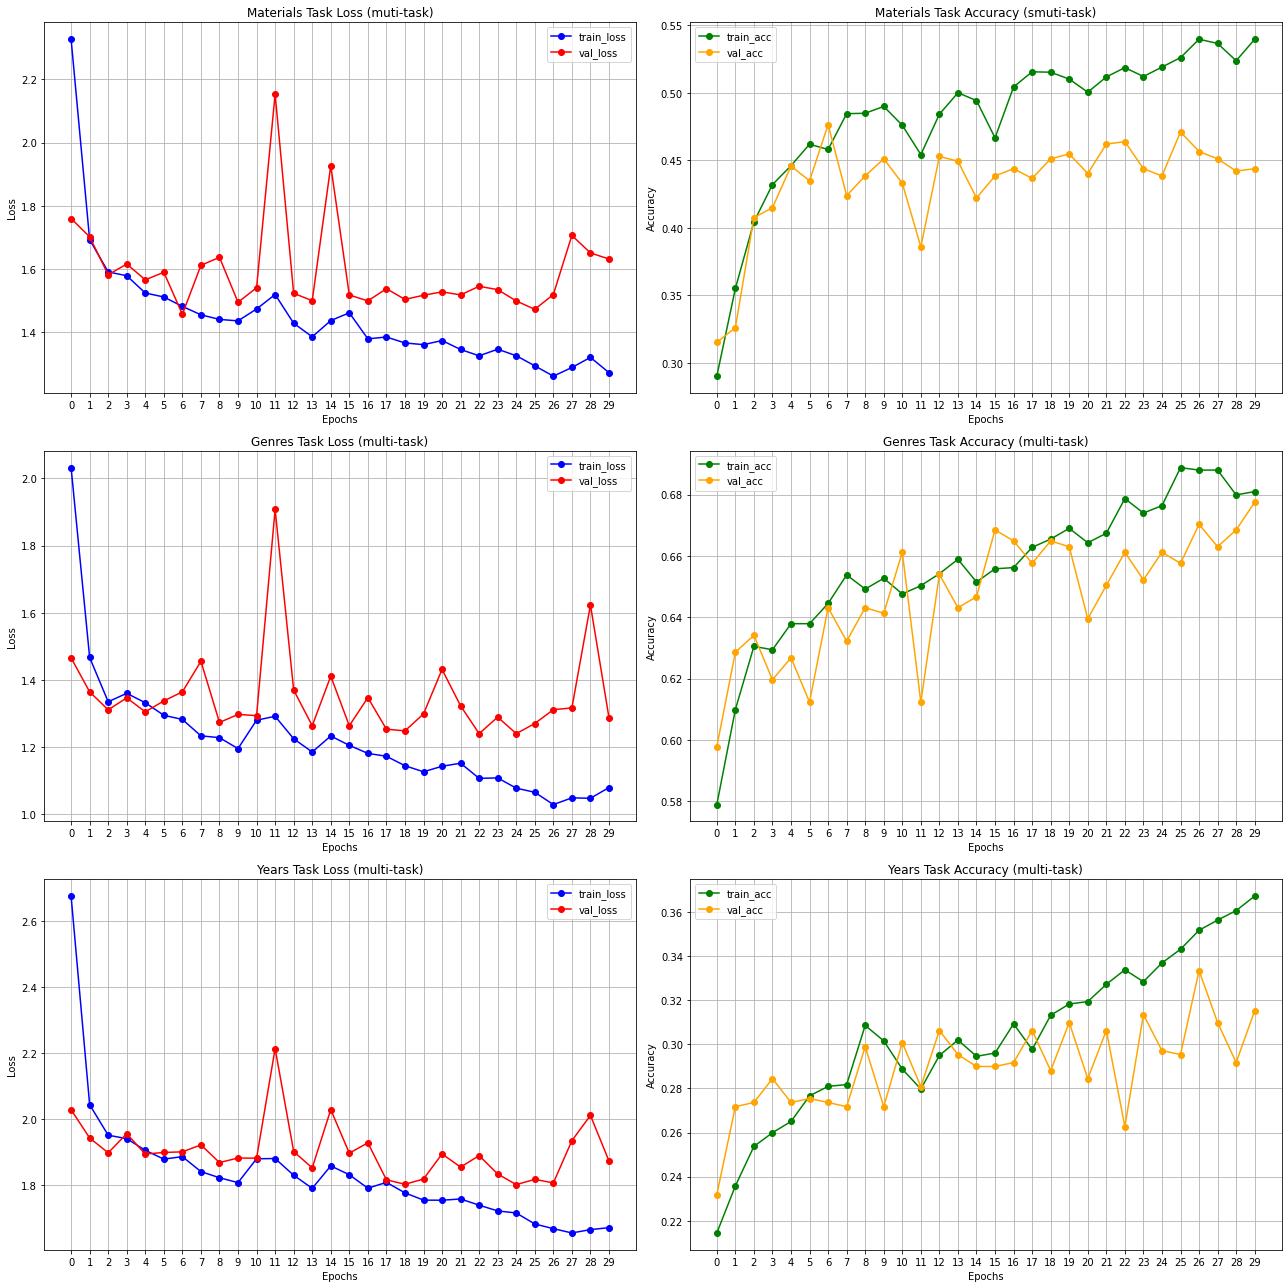

In [1]:
import matplotlib.pyplot as plt

epochs = list(range(30))


train_loss_materials = [2.3267, 1.6931, 1.5910, 1.5790, 1.5244, 1.5118, 1.4820, 1.4555, 1.4409, 1.4363, 1.4739, 1.5196, 1.4288, 1.3859, 1.4372, 1.4618, 1.3795, 1.3852, 1.3665, 1.3611, 1.3741, 1.3458, 1.3258, 1.3467, 1.3261, 1.2942, 1.2615, 1.2889, 1.3208, 1.2727]
val_loss_materials = [1.7599, 1.7019, 1.5822, 1.6160, 1.5661, 1.5899, 1.4569, 1.6119, 1.6372, 1.4951, 1.5410, 2.1535, 1.5234, 1.5001, 1.9268, 1.5182, 1.4993, 1.5381, 1.5042, 1.5172, 1.5280, 1.5184, 1.5457, 1.5349, 1.4993, 1.4727, 1.5196, 1.7065, 1.6511, 1.6319]
train_acc_materials = [0.2902, 0.3551, 0.4044, 0.4320, 0.4460, 0.4619, 0.4580, 0.4845, 0.4848, 0.4899, 0.4759, 0.4542, 0.4841, 0.5000, 0.4942, 0.4666, 0.5043, 0.5155, 0.5152, 0.5101, 0.5004, 0.5117, 0.5186, 0.5120, 0.5190, 0.5260, 0.5396, 0.5365, 0.5237, 0.5396]
val_acc_materials = [0.3152, 0.3261, 0.4076, 0.4149, 0.4457, 0.4348, 0.4764, 0.4239, 0.4384, 0.4511, 0.4330, 0.3859, 0.4529, 0.4493, 0.4221, 0.4384, 0.4438, 0.4366, 0.4511, 0.4547, 0.4402, 0.4620, 0.4638, 0.4438, 0.4384, 0.4710, 0.4565, 0.4511, 0.4420, 0.4438]

train_loss_genres = [2.0323, 1.4673, 1.3355, 1.3606, 1.3325, 1.2952, 1.2828, 1.2340, 1.2286, 1.1960, 1.2806, 1.2922, 1.2254, 1.1859, 1.2336, 1.2057, 1.1818, 1.1732, 1.1451, 1.1271, 1.1435, 1.1525, 1.1075, 1.1088, 1.0783, 1.0660, 1.0295, 1.0494, 1.0482, 1.0801]
val_loss_genres = [1.4660, 1.3650, 1.3114, 1.3471, 1.3055, 1.3380, 1.3650, 1.4560, 1.2739, 1.2977, 1.2943, 1.9078, 1.3704, 1.2641, 1.4115, 1.2641, 1.3478, 1.2539, 1.2488, 1.2992, 1.4317, 1.3233, 1.2406, 1.2898, 1.2406, 1.2707, 1.3119, 1.3171, 1.6236, 1.2880]
train_acc_genres = [0.5789, 0.6099, 0.6305, 0.6294, 0.6379, 0.6379, 0.6445, 0.6538, 0.6492, 0.6527, 0.6476, 0.6503, 0.6542, 0.6589, 0.6515, 0.6558, 0.6562, 0.6628, 0.6655, 0.6690, 0.6643, 0.6674, 0.6787, 0.6740, 0.6764, 0.6888, 0.6880, 0.6880, 0.6799, 0.6810]
val_acc_genres = [0.5978, 0.6286, 0.6341, 0.6196, 0.6268, 0.6123, 0.6431, 0.6322, 0.6431, 0.6413, 0.6612, 0.6123, 0.6540, 0.6431, 0.6467, 0.6685, 0.6649, 0.6576, 0.6649, 0.6630, 0.6395, 0.6504, 0.6612, 0.6522, 0.6612, 0.6576, 0.6703, 0.6630, 0.6685, 0.6775]

train_loss_time_period = [2.6756, 2.0438, 1.9514, 1.9410, 1.9057, 1.8790, 1.8865, 1.8412, 1.8226, 1.8078, 1.8801, 1.8807, 1.8302, 1.7905, 1.8585, 1.8317, 1.7909, 1.8086, 1.7769, 1.7548, 1.7545, 1.7583, 1.7395, 1.7221, 1.7159, 1.6826, 1.6684, 1.6554, 1.6655, 1.6714]
val_loss_time_period = [2.0285, 1.9431, 1.8981, 1.9558, 1.8942, 1.8992, 1.9010, 1.9221, 1.8686, 1.8823, 1.8818, 2.2137, 1.9020, 1.8524, 2.0289, 1.8970, 1.9283, 1.8164, 1.8028, 1.8186, 1.8947, 1.8548, 1.8897, 1.8340, 1.8018, 1.8177, 1.8068, 1.9349, 2.0114, 1.8734]
train_acc_time_period = [0.2145, 0.2358, 0.2537, 0.2599, 0.2650, 0.2766, 0.2809, 0.2817, 0.3085, 0.3015, 0.2887, 0.2797, 0.2949, 0.3019, 0.2945, 0.2960, 0.3092, 0.2976, 0.3131, 0.3182, 0.3193, 0.3271, 0.3337, 0.3283, 0.3368, 0.3430, 0.3516, 0.3562, 0.3605, 0.3671]
val_acc_time_period = [0.2319, 0.2717, 0.2736, 0.2844, 0.2736, 0.2754, 0.2736, 0.2717, 0.2989, 0.2717, 0.3007, 0.2808, 0.3062, 0.2953, 0.2899, 0.2899, 0.2917, 0.3062, 0.2880, 0.3098, 0.2844, 0.3062, 0.2627, 0.3134, 0.2971, 0.2953, 0.3333, 0.3098, 0.2917, 0.3152]


fig, axs = plt.subplots(3, 2, figsize=(18, 18))

axs[0, 0].plot(epochs, train_loss_materials, label='train_loss', color='blue', marker='o')
axs[0, 0].plot(epochs, val_loss_materials, label='val_loss', color='red', marker='o')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_title('Materials Task Loss (muti-task)')
axs[0, 0].legend()
axs[0, 0].grid(True)
axs[0, 0].set_xticks(epochs)

axs[0, 1].plot(epochs, train_acc_materials, label='train_acc', color='green', marker='o')
axs[0, 1].plot(epochs, val_acc_materials, label='val_acc', color='orange', marker='o')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].set_title('Materials Task Accuracy (smuti-task)')
axs[0, 1].legend()
axs[0, 1].grid(True)
axs[0, 1].set_xticks(epochs)



# Genres Task
axs[1, 0].plot(epochs, train_loss_genres, label='train_loss', color='blue', marker='o')
axs[1, 0].plot(epochs, val_loss_genres, label='val_loss', color='red', marker='o')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].set_title('Genres Task Loss (multi-task)')
axs[1, 0].legend()
axs[1, 0].grid(True)
axs[1, 0].set_xticks(epochs)

axs[1, 1].plot(epochs, train_acc_genres, label='train_acc', color='green', marker='o')
axs[1, 1].plot(epochs, val_acc_genres, label='val_acc', color='orange', marker='o')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_title('Genres Task Accuracy (multi-task)')
axs[1, 1].legend()
axs[1, 1].grid(True)
axs[1, 1].set_xticks(epochs)

# Time Period Task
axs[2, 0].plot(epochs, train_loss_time_period, label='train_loss', color='blue', marker='o')
axs[2, 0].plot(epochs, val_loss_time_period, label='val_loss', color='red', marker='o')
axs[2, 0].set_xlabel('Epochs')
axs[2, 0].set_ylabel('Loss')
axs[2, 0].set_title('Years Task Loss (multi-task)')
axs[2, 0].legend()
axs[2, 0].grid(True)
axs[2, 0].set_xticks(epochs)

axs[2, 1].plot(epochs, train_acc_time_period, label='train_acc', color='green', marker='o')
axs[2, 1].plot(epochs, val_acc_time_period, label='val_acc', color='orange', marker='o')
axs[2, 1].set_xlabel('Epochs')
axs[2, 1].set_ylabel('Accuracy')
axs[2, 1].set_title('Years Task Accuracy (multi-task)')
axs[2, 1].legend()
axs[2, 1].grid(True)
axs[2, 1].set_xticks(epochs)

# Adjust layout
plt.tight_layout()
plt.show()